# Validating the Approximation Result

This notebook validates the approximation result below by comparing $P_\infty$ obtained through our idealized framework of absorbing Markov chains with $P_{0:K}$ obtained via simulation.

**Theroem:** For a fixed game (with associated best-reply graph) and inertia parameters $\lambda^1, ..., \lambda^N$, consider the idealized best-reply process with inertia and the decentralized Q-learning algorithm. The idealized best-reply process has a constant transition kernel $P(G, \boldsymbol{\lambda})$ and absorption matrix $P_\infty$ (as defined above).
    
Suppose that Assumption 1 and Assumption 2 hold. In particular, $\delta^i \in (0, \bar{\delta}), \rho^i \in (0, \bar{\rho})$, for all $i$.
    
For any $\epsilon > 0$, there exists $\bar{K}$, such that for any given $K > \bar{K}, K < \infty$, there exists $\bar{T}_K$ such that if $T_k > \bar{T}_K$ for $k=0,...,K$, then
    \begin{equation*}
        Pr \Big[ \left|P_{0:K} - P_\infty \right|_\infty < \epsilon \Big] \geq 1 - \epsilon
    \end{equation*}

In [1]:
import itertools
import numpy as np
import networkx as nx

from tqdm import tqdm
from functools import partialmethod

from sympy import *
from sympy.interactive import printing
from IPython.display import Math, display

import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('..')
from multi_agent_learning import q_learning_alg1
from br_graph_analysis import learn_br_graph, transition_matrix_from_br_graph
import sim_utils

## Team 1: A 2-agent 2-action repeated team with 2 equilibria 

In [2]:
# define initial state distribution
def get_initial_state():
    return 0 # (there is only one state)


# defined reward_funcs
reward_matrix = np.array([[0, -1], [-1, 1]])

def reward(state, actions):
    u0, u1 = actions
    return reward_matrix[u0, u1]
    
reward_funcs = [reward, reward]


# define transition function
def transition_state(x, us):
    '''returns next state given current state and action'''
    return x


# define learning rate
r = 0.751 # 0.51
def alpha_func(n):
    return 1/(n**r)


# everyhting else
n_states = 1 # number of states
n_agents = 2 # number of agents

n_Us = [2] * n_agents # number of actions per agent (both agents have two actions)

experimentation_probs = [0.1]*n_agents # probability of experimentation at each action (\rho)
betas = [0]*n_agents # discount factor
deltas = [0]*n_agents # tolerance for suboptimality

agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))
jp_dict = {i: jp for i,jp in enumerate(joint_policy_space)}
inv_jp_dict = {jp: i for i,jp in jp_dict.items()}

Here, we have a repeated team with two agents, each having two actions to choose from. They have the following reward matrix:

In [3]:
Matrix(reward_matrix)

Matrix([
[ 0, -1],
[-1,  1]])

In [4]:
game_problem = n_Us, n_states, n_agents, reward_funcs, betas, get_initial_state, \
                 transition_state, experimentation_probs, alpha_func, deltas 

We choose the agents to have inertia parameter $\mathbf{\lambda} = (1/4, 3/4)$

In [5]:
agent_inertias = [0.25, 0.75]

In [6]:
# # learn BR-graph
# T = 1000
# init_state = 0
# br_graph = learn_br_graph(n_agents, n_states, n_Us, init_state, transition_state, reward_funcs, betas,
#                   T, experimentation_probs, alpha_func, deltas)
# nx.draw_spectral(br_graph, with_labels=True, arrowsize=40, edge_color='tab:grey')

This repeated team has the following best-reply graph

In [7]:
jp_order_ind = np.argsort(reward_matrix.flatten())[::-1]
jp_order = [joint_policy_space[i] for i in jp_order_ind]

br_graph = sim_utils.gen_br_graph_from_order(jp_order, jp_dict)

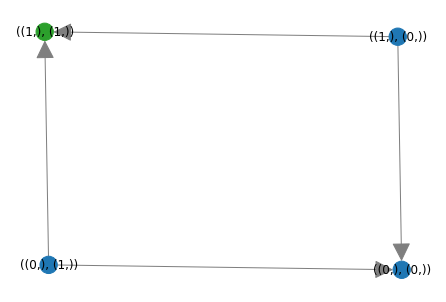

In [8]:
node_colors = ['tab:blue']*len(jp_order)
team_optimal_policy_ind = inv_jp_dict[jp_order[0]]
node_colors[team_optimal_policy_ind] = 'tab:green'
nx.draw_spectral(br_graph, with_labels=True, arrowsize=40, edge_color='tab:grey', node_color=node_colors)

In [9]:
team_opt_policy = jp_order[0]
inertias_syms, team_opt_prob, (P_ro, Q, R, N, B, P_inf_can) = \
        sim_utils.get_team_opt_prob(team_opt_policy, br_graph, jp_dict, return_all=True)

Via our results studying the idealized best-reply process through absorbing Markov chains, we get the following theoretical/idealized estimate for $P_\infty$

In [10]:
P_inf_can.subs(dict(zip(inertias_syms, agent_inertias)))

Matrix([
[0, 0, 0.25, 0.75],
[0, 0, 0.75, 0.25],
[0, 0,    1,    0],
[0, 0,    0,    1]])

And, through 10,000 simulation runs, we emperically estimate $P_{0:K} \approx P_\infty$. We find that it is very close to the theoretical values.

In [11]:
(markov_transition_prob, emperical_transition_matrix), (markov_end_prob, emperical_end_probs) = \
            sim_utils.get_emperical_abs_probs(game_problem, agent_inertias, n_trials=10_000)

100%|██████████████| 10000/10000 [36:54<00:00,  4.52it/s]


In [12]:
Matrix(sim_utils.reorder_matrix_by_states(emperical_end_probs,jp_order_ind[::-1])).evalf(4)

Matrix([
[0, 0, 0.2537, 0.7463],
[0, 0, 0.7542, 0.2458],
[0, 0,    1.0,      0],
[0, 0,      0,    1.0]])

# Team 2: a 2-agent 3-action repeated team with 2 equilibria

In [13]:
# define initial state distribution
def get_initial_state():
    return 0 # (there is only one state)


# defined reward_funcs
reward_matrix = np.array([[7., 2., 1.],
                           [3., 5., 6.],
                           [0., 8., 4.]])

def reward(state, actions):
    u0, u1 = actions
    return reward_matrix[u0, u1]
    
reward_funcs = [reward, reward]


# define transition function
def transition_state(x, us):
    '''returns next state given current state and action'''
    return x


# define learning rate
r = 0.751 # 0.51
def alpha_func(n):
    return 1/(n**r)


# everyhting else
n_states = 1 # number of states
n_agents = 2 # number of agents

n_Us = [3] * n_agents # number of actions per agent (both agents have two actions)

experimentation_probs = [0.1]*n_agents # probability of experimentation at each action (\rho)
betas = [0]*n_agents # discount factor
deltas = [0]*n_agents # tolerance for suboptimality

agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))
jp_dict = {i: jp for i,jp in enumerate(joint_policy_space)}
inv_jp_dict = {jp: i for i,jp in jp_dict.items()}

Here, we have a repeated team with two agents, each having two actions to choose from. They have the following reward matrix:

In [14]:
Matrix(reward_matrix)

Matrix([
[7.0, 2.0, 1.0],
[3.0, 5.0, 6.0],
[0.0, 8.0, 4.0]])

We choose the agents to have inertia parameter $\mathbf{\lambda} = (1/4, 3/4)$

In [15]:
game_problem = n_Us, n_states, n_agents, reward_funcs, betas, get_initial_state, \
                 transition_state, experimentation_probs, alpha_func, deltas 

In [16]:
jp_order_ind = reward_matrix.flatten().argsort()[::-1]
jp_order = [jp_dict[i] for i in jp_order_ind]

This repeated team has the following best-reply graph

In [17]:
# learn BR-graph
T = 10000
init_state = 0
br_graph = learn_br_graph(n_agents, n_states, n_Us, init_state, transition_state, reward_funcs, betas,
                  T, experimentation_probs, alpha_func, deltas)

br_graph_ = nx.DiGraph.copy(br_graph)
br_graph_.remove_edges_from(nx.selfloop_edges(br_graph_))

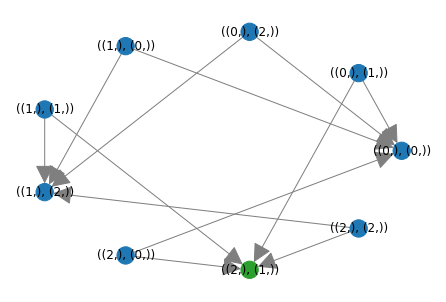

In [18]:
node_colors = ['tab:blue']*len(jp_order)
team_optimal_policy_ind = inv_jp_dict[jp_order[0]]
node_colors[team_optimal_policy_ind] = 'tab:green'
nx.draw_circular(br_graph_, with_labels=True, arrowsize=40, edge_color='tab:grey', node_color=node_colors)
# nx.draw_circular(br_graph_, with_labels=True, arrowsize=40, edge_color='tab:grey')

In [19]:
team_opt_policy = jp_order[0]
inertias_syms, team_opt_prob, (P_ro, Q, R, N, B, P_inf_can) = \
        sim_utils.get_team_opt_prob(team_opt_policy, br_graph_, jp_dict, return_all=True)

Via our results studying the idealized best-reply process through absorbing Markov chains, we get the following theoretical/idealized estimate for $P_\infty$ and the final distribution

In [20]:
P_inf_can.subs(dict(zip(inertias_syms, agent_inertias)))

Matrix([
[0, 0, 0, 0, 0, 0, 0.25,    0, 0.75],
[0, 0, 0, 0, 0, 0, 0.25, 0.75,    0],
[0, 0, 0, 0, 0, 0, 0.75, 0.25,    0],
[0, 0, 0, 0, 0, 0,    0, 0.25, 0.75],
[0, 0, 0, 0, 0, 0, 0.75,    0, 0.25],
[0, 0, 0, 0, 0, 0,    0, 0.75, 0.25],
[0, 0, 0, 0, 0, 0,    1,    0,    0],
[0, 0, 0, 0, 0, 0,    0,    1,    0],
[0, 0, 0, 0, 0, 0,    0,    0,    1]])

In [21]:
uniform_dist = Matrix([1/len(joint_policy_space)]*len(joint_policy_space)).T
final_dist = simplify(Matrix(uniform_dist @ P_inf_can))
final_dist

Matrix([[0, 0, 0, 0, 0, 0, 0.333333333333333, 0.333333333333333, 0.333333333333333]])

And, through 10,000 simulation runs, we emperically estimate $P_{0:K} \approx P_\infty$. We find that it is very close to the theoretical values.

In [22]:
(markov_transition_prob, emperical_transition_matrix), (markov_end_prob, emperical_end_probs) = \
            sim_utils.get_emperical_abs_probs(game_problem, agent_inertias, n_trials=10_000)

100%|██████████████| 10000/10000 [34:53<00:00,  4.78it/s]


In [23]:
abs_states = [inv_jp_dict[node] for node in br_graph_.nodes if br_graph_.out_degree(node) == 0]
trans_states = [i for i in range(len(joint_policy_space)) if i not in abs_states]
team_opt = inv_jp_dict[team_opt_policy]

# reorder abs_states so that team-optimal state is at the end
abs_states.remove(team_opt)
abs_states.append(team_opt)

reorder = trans_states + abs_states

In [24]:
Matrix(sim_utils.reorder_matrix_by_states(emperical_end_probs,reorder)).evalf(4)

Matrix([
[0, 0, 0, 0, 0, 0, 0.2517,      0,   0.7483],
[0, 0, 0, 0, 0, 0, 0.2491, 0.7509,        0],
[0, 0, 0, 0, 0, 0, 0.7456, 0.2518, 0.002641],
[0, 0, 0, 0, 0, 0,      0, 0.2606,   0.7394],
[0, 0, 0, 0, 0, 0,  0.753,      0,    0.247],
[0, 0, 0, 0, 0, 0,      0, 0.7561,   0.2439],
[0, 0, 0, 0, 0, 0,    1.0,      0,        0],
[0, 0, 0, 0, 0, 0,      0,    1.0,        0],
[0, 0, 0, 0, 0, 0,      0,      0,      1.0]])

In [25]:
uniform_dist = Matrix([1/len(joint_policy_space)]*len(joint_policy_space)).T
final_dist = simplify(Matrix(uniform_dist @ Matrix(sim_utils.reorder_matrix_by_states(emperical_end_probs,reorder)).evalf(4)))
final_dist

Matrix([[0, 0, 0, 0, 0, 0, 0.333269966973199, 0.335482703314887, 0.3312466012107]])